# Application of VGG16 (Transfer Learning): using VGGFace weights for Race Classification



## 1. Dataset

In [1]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 27.7 MB/s eta 0:00:00


In [2]:
#!pip install keras-vggface

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import set_random_seed
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import keras_cv

In [4]:
# Setting the seed
seed = 42
set_random_seed(seed)
np.random.seed(42)

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
folder_path = "/content/drive/My Drive/UTKFace_retina_cropped_100x100"

In [7]:
cnt = 0
for file in sorted(os.listdir(folder_path)):  # Sort file list
  file_path = os.path.join(folder_path,file)
  cnt = cnt + 1

print(f"Number of face images: {cnt}")

Number of face images: 23561


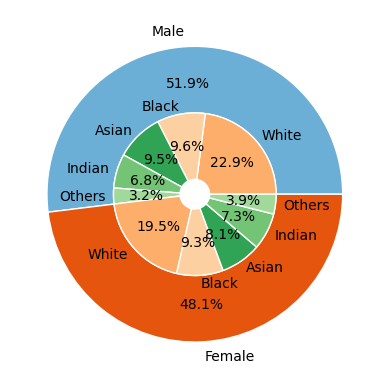

In [8]:
# age: is an integer from 0 to 116, indicating the age
# gender: is either 0 (male) or 1 (female)
# race: is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

column_names = ['Age', 'Gender', 'Race']
records = []

for file in os.listdir(folder_path):
  records.append(file.split('_')[:-1])

DFrame=pd.DataFrame(records, columns=column_names).astype(int)

# EDA: Pie chart:
fig, ax = plt.subplots()
cmap = plt.colormaps["tab20c"]
outer_colors = cmap([1,4])
inner_colors = cmap([6,7,8,9,10, 6,7,8,9,10])
size = 0.45
pctdist = 0.75

DF_tot = DFrame['Gender'].value_counts()

# Outer pie chart
ax.pie(
    np.array(DF_tot),
    autopct='%1.1f%%',
    pctdistance = pctdist,
    radius=1.0,
    colors=outer_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    labels=['Male', 'Female']    #[0, 1]
);

# Counts of races in females
DF_F = DFrame.Race[DFrame['Gender']==1].value_counts()

# Counts of races in males
DF_M = DFrame.Race[DFrame['Gender']==0].value_counts()

# Concatenate arrays, for use in inner pie chart
concat_arrays= np.concatenate((np.array(DF_M), np.array(DF_F)))  #T, F

# Inner pie chart (to show sub-distribution of "race")
ax.pie(
    concat_arrays,
    autopct='%1.1f%%',
    radius=1.0-size,
    colors=inner_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    labels=['White','Black','Asian','Indian', 'Others',
            'White','Black','Asian','Indian', 'Others',]
);

Text(0.5, 1.0, 'Distribution of race in the UTKFace dataset')

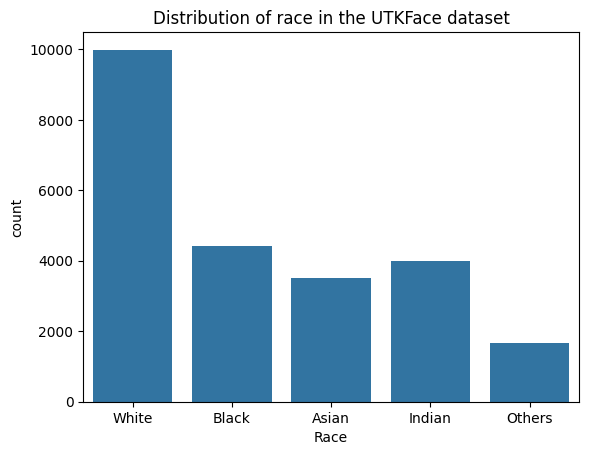

In [9]:
# Race Mapping
race_mapping = {
    0 : 'White',
    1 : 'Black',
    2 : 'Asian',
    3 : 'Indian',
    4 : 'Others'
}

# Replace the integers with correct race
DFrame['Race'] = DFrame['Race'].replace(race_mapping)

# Specify the order of categories based on race_mapping
race_order = list(race_mapping.values())

# Count plot
plt.figure()
sns.countplot(x='Race', data=DFrame, order=race_order)
plt.title('Distribution of race in the UTKFace dataset')

In [10]:
def read_image(fname):
    # Extract label from file name
    parts = tf.strings.split(fname, os.sep)
    file_name = parts[-1]
    multiple_labels = tf.strings.split(file_name, '_')

    # Convert race label to integer
    label = tf.strings.to_number(multiple_labels[2], out_type=tf.int32)

    # Load and decode the image
    image = tf.io.read_file(fname)
    image = tf.io.decode_jpeg(image)
    return image, label

In [11]:
# Creating training, validation and test sets...
list_ds = tf.data.Dataset.list_files(folder_path + "/*")

# Total number of files
file_count = len(list_ds)

# Define split sizes
train_size = int(0.8 * file_count)  # 80% for training
val_size = int(0.1 * file_count)    # 10% for validation
test_size = file_count - train_size - val_size  # Remaining 10% for testing

# Shuffle the dataset before splitting
list_ds = list_ds.shuffle(buffer_size=file_count, seed=42)

# Split into training, validation, and test datasets
train_list_ds = list_ds.take(train_size)  # First 80% for training
val_list_ds = list_ds.skip(train_size).take(val_size)  # Next 10% for validation
test_list_ds = list_ds.skip(train_size + val_size)  # Remaining 10% for test

# for element in list_ds.as_numpy_iterator():
#   print(element)
#   break

In [12]:
# Example check
for image, label in list_ds.map(read_image).take(5):
    print("Label:", label)

Label: tf.Tensor(0, shape=(), dtype=int32)
Label: tf.Tensor(3, shape=(), dtype=int32)
Label: tf.Tensor(1, shape=(), dtype=int32)
Label: tf.Tensor(3, shape=(), dtype=int32)
Label: tf.Tensor(0, shape=(), dtype=int32)


Race label: Black, label integer: 1
(100, 100, 3)


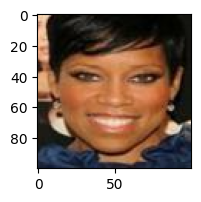

In [13]:
labels = ["White", "Black", "Asian", "Indian", "Others"]
for element in list_ds.as_numpy_iterator():
  img, lab = read_image(element)
  fig, ax = plt.subplots(figsize=(2,2))
  ax.imshow(img)
  print(f'Race label: {labels[lab.numpy()]}, label integer: {lab.numpy()}')
  print(img.shape)
  break

In [14]:
# Define the rotation layer outside the function for reuse
rotation_layer = keras_cv.layers.RandomRotation(factor=0.111)  # 0.111 ~= 20 degrees

# RGB mean values to subtract

mean_vector = [91.4953, 103.8827, 131.0912]

def preprocess_image(image, label, augment=False, mean_vector=mean_vector):
    # Convert image to float32 and normalize to [0,1] if not already done in the dataset pipeline
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    if augment:
        # Apply augmentation
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        image = tf.image.random_hue(image, max_delta=0.05)

        # Rotate up to 20 degrees using KerasCV
        image = rotation_layer(image)

    # Subtract RGB mean values
    mean_values = tf.constant(mean_vector, dtype=tf.float32)
    image = image - mean_values / 255.0  # Normalize mean values to [0,1] scale

    return image, label


In [15]:
# Batch size for training
batch_size = 128

# Preparing the datasets
train_ds = (
    train_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, lbl: preprocess_image(img, lbl, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

# Validation dataset without augmentation
val_ds = (
    val_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, lbl: preprocess_image(img, lbl, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

# Test dataset without augmentation
test_ds = (
    test_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, lbl: preprocess_image(img, lbl, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

## 2. Building a CNN using Transfer Learning on VGG16
Input image shape: (100, 100, 3)

Let's include VGG16 model without the top

In [16]:

img_input = layers.Input((100, 100, 3), dtype='float32', name='base_model')
# Block 1
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(img_input)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

# Block 2
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

# Block 3
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

# Block 4
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

# Block 5
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

# Define the base model
base_model = models.Model(inputs=img_input, outputs=x, name='base_vgg_model')

#weights_path = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_vgg16.h5'
# https://github.com/rcmalli/keras-vggface/tree/master


weights_path = "/content/drive/My Drive/VGGFace weights/rcmalli_vggface_tf_notop_vgg16.h5"
#https://github.com/rcmalli/keras-vggface/releases
base_model.load_weights(weights_path)

for layer in base_model.layers[:15]:
    layer.trainable = False


# Number of output classes (customize this based on your problem)
num_classes = 5  # Replace with the actual number of classes

# Build custom classification layers on top of the frozen base model
x_in = base_model.output
x = layers.Reshape((-1,))(x_in)  # Reshape to a single vector
x = layers.Dense(128, activation='relu')(x)
out = layers.Dense(num_classes, activation='softmax')(x)

# Combine base model and custom layers
model = models.Model(inputs=base_model.input, outputs=out, name='custom_VGG_model')

# Print the full custom model summary
print("\nMy VGG model with custom classifier:")
model.summary()


My VGG model with custom classifier:


Model: "custom_VGG_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ base_model (InputLayer)              │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_1 (Conv2D)                     │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_2 (Conv2D)                     │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1 (Conv2D)                     │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_2 (Conv2D)                     │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_1 (Conv2D)                     │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_2 (Conv2D)                     │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_3 (Conv2D)                     │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_1 (Conv2D)                     │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_2 (Conv2D)                     │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_3 (Conv2D)                     │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5_1 (Conv2D)                     │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5_2 (Conv2D)                     │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5_3 (Conv2D)                     │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool5 (MaxPooling2D)                 │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,305,285 (58.39 MB)

 Trainable params: 7,670,021 (29.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [17]:
# Print layer numbers and details
cnt = 1
for layer in model.layers:
    print(f'{cnt}: {layer.name} - {"Trainable" if layer.trainable else "Frozen"}')
    cnt += 1


1: base_model - Frozen
2: conv1_1 - Frozen
3: conv1_2 - Frozen
4: pool1 - Frozen
5: conv2_1 - Frozen
6: conv2_2 - Frozen
7: pool2 - Frozen
8: conv3_1 - Frozen
9: conv3_2 - Frozen
10: conv3_3 - Frozen
11: pool3 - Frozen
12: conv4_1 - Frozen
13: conv4_2 - Frozen
14: conv4_3 - Frozen
15: pool4 - Frozen
16: conv5_1 - Trainable
17: conv5_2 - Trainable
18: conv5_3 - Trainable
19: pool5 - Trainable
20: reshape - Trainable
21: dense - Trainable
22: dense_1 - Trainable


In [18]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the checkpoint path in Google Drive
checkpoint_path = '/content/drive/MyDrive/model_checkpoints/best_weights_10_1_3.keras'

# Create the checkpoint callback
mc_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy',
                              save_best_only=True, mode='max')

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * float(tf.math.exp(-0.01))

lr_callback = LearningRateScheduler(scheduler)


# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
# My model’s last layer has a softmax activation, thus from_logits=False

In [19]:
history = model.fit(train_ds, epochs=20,
                    batch_size=batch_size, validation_data=val_ds,
                    callbacks=[mc_callback, lr_callback])  #batch_size=128

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 468s 3s/step - accuracy: 0.5908 - loss: 1.0731 - val_accuracy: 0.7780 - val_loss: 0.6465 - learning_rate: 1.0000e-04
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 61s 173ms/step - accuracy: 0.7716 - loss: 0.6573 - val_accuracy: 0.8256 - val_loss: 0.5056 - learning_rate: 1.0000e-04
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 26s 173ms/step - accuracy: 0.8279 - loss: 0.5108 - val_accuracy: 0.8574 - val_loss: 0.4262 - learning_rate: 1.0000e-04
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 40s 167ms/step - accuracy: 0.8755 - loss: 0.3836 - val_accuracy: 0.8837 - val_loss: 0.3605 - learning_rate: 1.0000e-04
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - accuracy: 0.9071 - loss: 0.2793 - val_accuracy: 0.8943 - val_loss: 0.3273 - learning_rate: 1.0000e-04
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 172ms/step - accuracy: 0.9270 - loss: 0.2257 - val_accuracy: 0.9189 - val_loss: 0.2595 - learning_rate: 1.0000e-04
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 24s 161m

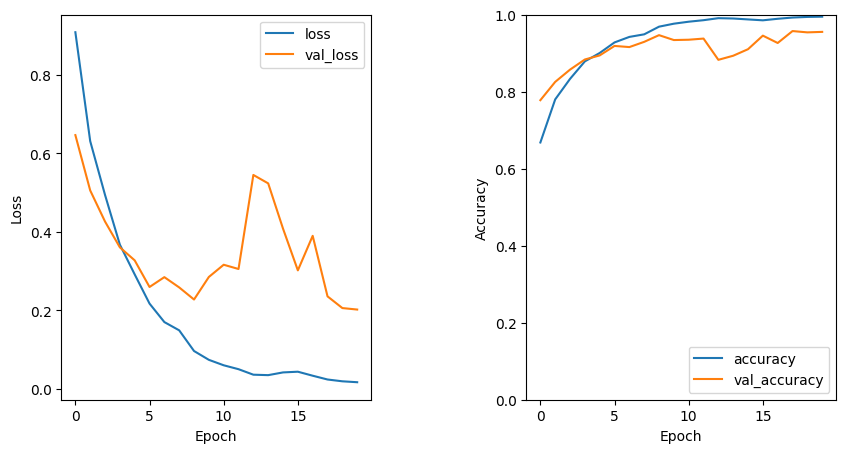

In [20]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(hspace=0.1, wspace=0.5)

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label = 'val_loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper right')

axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label = 'val_accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 1])
axs[1].legend(loc='lower right')

### Evaluating the model

In [21]:
#Loading the weights of the model with best validation accuracy
model.load_weights(checkpoint_path)
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print("")
print(f"test_loss = {np.round(test_loss,4)}, test_acc = {np.round(test_acc,4)}")

19/19 - 13s - 699ms/step - accuracy: 0.9627 - loss: 0.2618

test_loss = 0.2618, test_acc = 0.9627


In [22]:
def unpreprocess_image(image, mean_vector=mean_vector):
    # Subtract RGB mean values
    mean_values = tf.constant(mean_vector, dtype=tf.float32)
    image = image + mean_values/255
    return image

### Visualising some predictions made by VGG16 model

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step


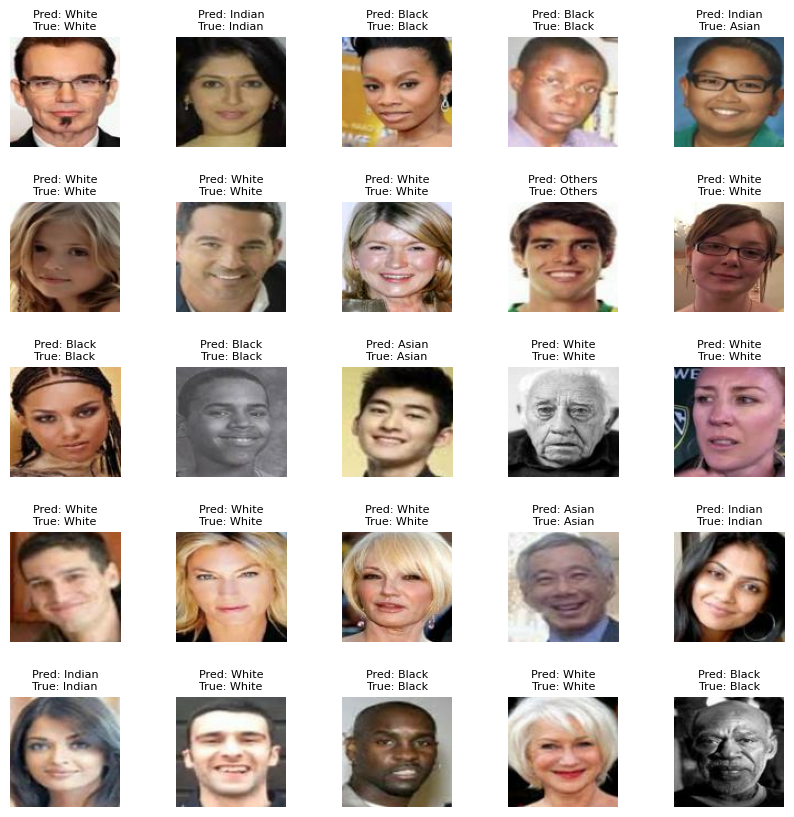

In [23]:
string_labels = ["White", "Black", "Asian", "Indian", "Others"]

# First, get predictions for validation images
predicted_scores = model.predict(test_ds)
predicted_labels = np.argmax(predicted_scores, axis=1)

# Convert numerical labels back to class names
index_to_label = [string_labels[label] for label in predicted_labels]

# Initialize lists to store images and labels
true_labels = []
images = []

# Loop through test_ds to collect images and labels
for image_batch, label_batch in test_ds:
    images.append(image_batch.numpy())  # Convert to NumPy array
    true_labels.append(label_batch.numpy())

# Convert the list of arrays into a single NumPy array for each
images = np.concatenate(images, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Select 25 random indices from the test set
random_indices = np.random.choice(len(images), size=25, replace=False)

# Plot the selected images with predicted and true labels
f, ax = plt.subplots(5, 5, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
ax = ax.ravel()

for i, idx in enumerate(random_indices):
    ax[i].imshow(unpreprocess_image(images[idx]))
    ax[i].set_title(f"Pred: {string_labels[predicted_labels[idx]]}\nTrue: {string_labels[true_labels[idx]]}")
    ax[i].title.set_size(8)
    ax[i].axis('off')

plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step


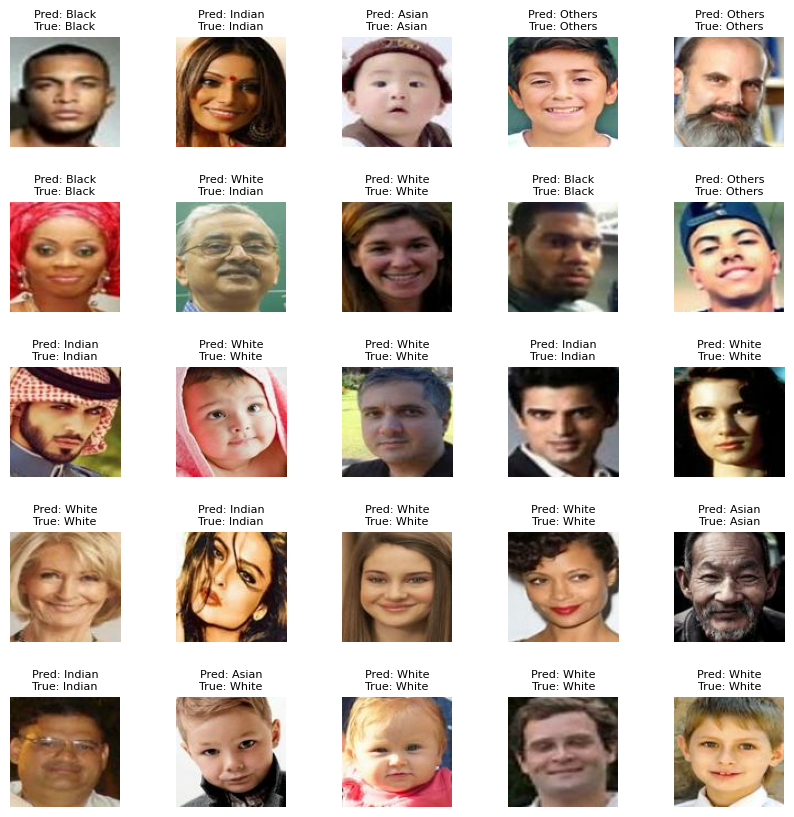

In [26]:
string_labels = ["White", "Black", "Asian", "Indian", "Others"]

# First, get predictions for validation images
predicted_scores = model.predict(test_ds)
predicted_labels = np.argmax(predicted_scores, axis=1)

# Convert numerical labels back to class names
index_to_label = [string_labels[label] for label in predicted_labels]

# Initialize lists to store images and labels
true_labels = []
images = []

# Loop through test_ds to collect images and labels
for image_batch, label_batch in test_ds:
    images.append(image_batch.numpy())  # Convert to NumPy array
    true_labels.append(label_batch.numpy())

# Convert the list of arrays into a single NumPy array for each
images = np.concatenate(images, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Select 25 random indices from the test set
random_indices = np.random.choice(len(images), size=25, replace=False)

# Plot the selected images with predicted and true labels
f, ax = plt.subplots(5, 5, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
ax = ax.ravel()

for i, idx in enumerate(random_indices):
    ax[i].imshow(unpreprocess_image(images[idx]))
    ax[i].set_title(f"Pred: {string_labels[predicted_labels[idx]]}\nTrue: {string_labels[true_labels[idx]]}")
    ax[i].title.set_size(8)
    ax[i].axis('off')

plt.show()


### Visualising the confusion matrix

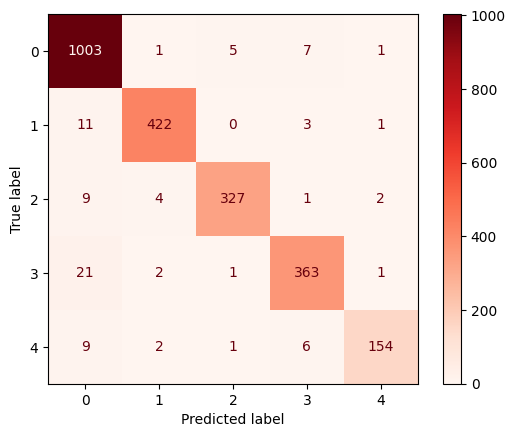

In [24]:
y_pred= [label for label in predicted_labels]
y_true = [label for label in true_labels]

classes = np.arange(5)
cm = confusion_matrix(y_true, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Reds')

### Classification report

In [25]:
# Use classification_report to get precision and recall
classification_report_result = classification_report(y_true, y_pred)

print("\nClassification Report:")
print(classification_report_result)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1017
           1       0.98      0.97      0.97       437
           2       0.98      0.95      0.97       343
           3       0.96      0.94      0.95       388
           4       0.97      0.90      0.93       172

    accuracy                           0.96      2357
   macro avg       0.97      0.95      0.96      2357
weighted avg       0.96      0.96      0.96      2357

